<a href="https://colab.research.google.com/github/Aulianadya/PEMODELAN--SIMULASI/blob/main/heat_transfer_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

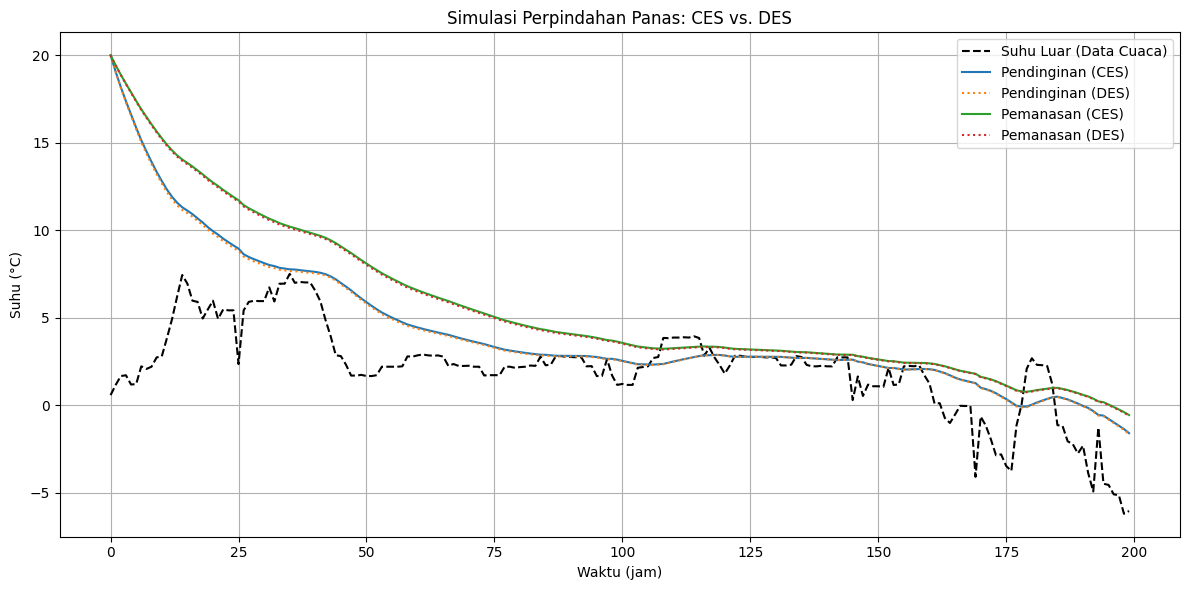

📋 Hasil Simulasi (10 jam pertama):
   Jam  Suhu Luar (°C)  CES Pendinginan (°C)  DES Pendinginan (°C)  \
0    0            0.58                 20.00                 20.00   
1    1            1.16                 19.05                 19.03   
2    2            1.67                 18.18                 18.14   
3    3            1.71                 17.37                 17.31   
4    4            1.18                 16.61                 16.53   
5    5            1.21                 15.86                 15.76   
6    6            2.22                 15.14                 15.04   
7    7            2.07                 14.51                 14.40   
8    8            2.20                 13.91                 13.78   
9    9            2.73                 13.34                 13.20   

   CES Pemanasan (°C)  DES Pemanasan (°C)  
0               20.00               20.00  
1               19.43               19.42  
2               18.89               18.87  
3               18

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# 1. Baca dataset dan atur zona waktu UTC agar parsing aman
df = pd.read_csv('/content/weatherHistory.csv')
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], utc=True)

# 2. Set sebagai index waktu
df = df.set_index('Formatted Date')

# 3. Resample per jam ('h') dan interpolasi data yang kosong
df = df[['Temperature (C)']].resample('h').mean().interpolate()

# 4. Ambil sebagian data untuk simulasi (200 jam pertama)
df = df.iloc[:200]

# 5. Siapkan data suhu luar dan waktu simulasi
T_ext = df['Temperature (C)'].values
time = np.arange(len(T_ext))  # waktu dalam jam

# 6. Model pendinginan
def model_pendinginan(T, t, k, T_ext_func):
    T_luar = T_ext_func(int(t)) if int(t) < len(T_ext) else T_ext[-1]
    return -k * (T - T_luar)

# 7. Model pemanasan
def model_pemanasan(T, t, k, T_ext_func):
    T_luar = T_ext_func(int(t)) if int(t) < len(T_ext) else T_ext[-1]
    return k * (T_luar - T)

# 8. Fungsi suhu luar berbasis waktu
T_ext_func = lambda t: T_ext[int(t)] if t < len(T_ext) else T_ext[-1]

# 9. Parameter awal simulasi
suhu_awal = 20
k_pendinginan = 0.05
k_pemanasan = 0.03

# 10. Simulasi CES
T_CES_pendingin = odeint(model_pendinginan, suhu_awal, time, args=(k_pendinginan, T_ext_func)).flatten()
T_CES_pemanas = odeint(model_pemanasan, suhu_awal, time, args=(k_pemanasan, T_ext_func)).flatten()

# 11. Simulasi DES (Euler)
def simulasi_des(model_func, k, suhu_awal):
    T = np.zeros_like(time, dtype=float)
    T[0] = suhu_awal
    for i in range(1, len(time)):
        T[i] = T[i-1] + model_func(T[i-1], i-1, k, T_ext_func)
    return T

model_des_pendingin = lambda T, t, k, T_ext_func: -k * (T - T_ext_func(t))
model_des_pemanas = lambda T, t, k, T_ext_func: k * (T_ext_func(t) - T)

T_DES_pendingin = simulasi_des(model_des_pendingin, k_pendinginan, suhu_awal)
T_DES_pemanas = simulasi_des(model_des_pemanas, k_pemanasan, suhu_awal)

# 12. Plot hasil simulasi
plt.figure(figsize=(12, 6))
plt.plot(time, T_ext, 'k--', label='Suhu Luar (Data Cuaca)')
plt.plot(time, T_CES_pendingin, label='Pendinginan (CES)', linestyle='solid')
plt.plot(time, T_DES_pendingin, label='Pendinginan (DES)', linestyle='dotted')
plt.plot(time, T_CES_pemanas, label='Pemanasan (CES)', linestyle='solid')
plt.plot(time, T_DES_pemanas, label='Pemanasan (DES)', linestyle='dotted')
plt.xlabel('Waktu (jam)')
plt.ylabel('Suhu (°C)')
plt.title('Simulasi Perpindahan Panas: CES vs. DES')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 13. Buat DataFrame untuk menampilkan hasil simulasi
hasil_simulasi = pd.DataFrame({
    'Jam': time,
    'Suhu Luar (°C)': T_ext,
    'CES Pendinginan (°C)': T_CES_pendingin,
    'DES Pendinginan (°C)': T_DES_pendingin,
    'CES Pemanasan (°C)': T_CES_pemanas,
    'DES Pemanasan (°C)': T_DES_pemanas,
})

# 14. Tampilkan 10 data pertama
print("📋 Hasil Simulasi (10 jam pertama):")
print(hasil_simulasi.head(10).round(2))

